# Assignment 2 Math Foundations Machine Learning
## David Alvear 187594

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

# 4. Iris Classification

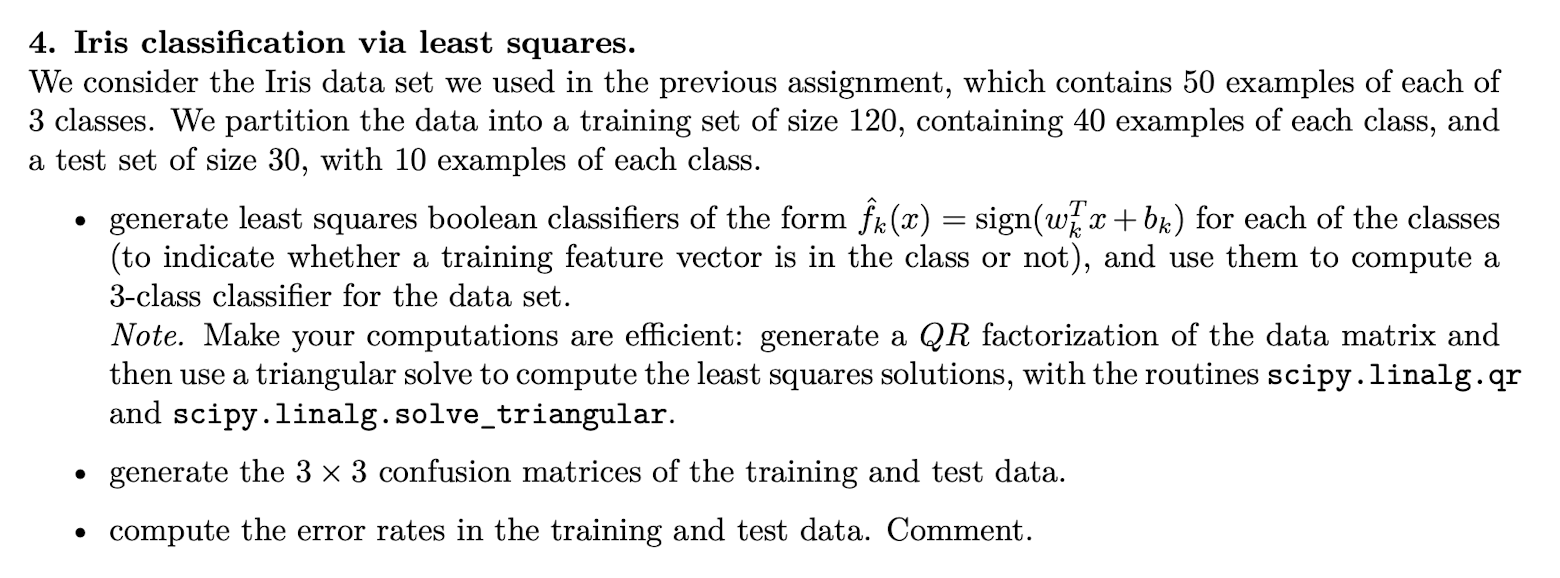

Text(0.5, 0, 'petal_length')

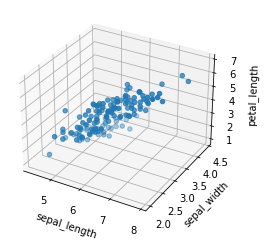

In [2]:
# you may want to write your kmeans routine separately (in a kmeans.py file) and import it here
# from kmeans import kmeans

# read the iris data
df = pd.read_csv('data/iris.csv')
feature_names = df.keys()
X = df.iloc[:, 0:4].to_numpy()

# 3d scatter plot of training vectors
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X[:, 0], X[:,1], X[:,2])
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])

In [12]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [35]:
##########################################
############## Prepare Data ##############
##########################################

class DataLoader:
    def __init__(self, data:pd.DataFrame, train_size=40, class_col='species', labels=['Iris-setosa','Iris-versicolor','Iris-virginica']):
        self.data = data
        self.class_col = class_col
        self.labels = labels
        # separate the data
        train_frames = []
        test_frames = []

        for label in self.labels:
            class_data = self.data[self.data[class_col] == label]
            train, test = self.partition_data(class_data, train_size=train_size)
            train_frames.append(train)
            test_frames.append(test)

        self.train_data = pd.concat(train_frames)
        self.test_data = pd.concat(test_frames)
        # shuffle the data
        self.train_data = self.train_data.sample(frac=1).reset_index(drop=True)
        self.test_data = self.test_data.sample(frac=1).reset_index(drop=True)
        # get train and test labels
        self.train_labels = self.train_data[self.class_col].copy()
        self.test_labels = self.test_data[self.class_col].copy()
    
    def get_train_test_data(self, label_index):
        x_train = self.train_data.iloc[:, 0:label_index].to_numpy()
        x_test = self.test_data.iloc[:, 0:label_index].to_numpy()
        return x_train, x_test

    def partition_data(self, data, train_size=40):
        # use the key to get the corresponding data
        train = data[:train_size]
        test = data[train_size:]
        return train, test

    def get_single_class_label(self, label):
        train = self.train_labels.copy()
        test = self.test_labels.copy()
        train = train.apply(lambda x: 1 if x == label else -1)
        test = test.apply(lambda x: 1 if x == label else -1)
        return train, test

    def get_multiclass_labels_data(self):
        train = self.train_labels.copy()
        test = self.test_labels.copy()
        for idx, label in enumerate(self.labels):
            train.loc[train == label] = idx
            test.loc[test == label] = idx
        train = train.to_numpy()
        test = test.to_numpy()
        return train.astype(int), test.astype(int)


##########################################
############## Boolean classifier ########
##########################################

class BoolClassifier:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.w_b = None

    def train(self, mode='solve_triangular'):
        n, m = self.x_train.shape
        train = np.hstack([self.x_train, np.ones((self.x_train.shape[0], 1))])
        if mode == 'solve_triangular':
            # QR factorization
            Q, R = scipy.linalg.qr(train)
            Q = Q[:,:m+1]
            R = R[:m+1,:]
            # solve least squares problem
            self.w_b = scipy.linalg.solve_triangular(R, np.dot(Q.T, self.y_train))
        elif mode == 'solve':
            self.w_b = scipy.linalg.solve(np.dot(train.T, train), np.dot(train.T, self.y_train))

    def predict(self, test_data: np.ndarray):
        # predict
        if self.w_b is None:
            return None # not trained yet
        test_data = np.hstack([test_data, np.ones((test_data.shape[0], 1))])
        linear_out = np.dot(test_data, self.w_b)
#         predictions = np.sign(linear_out)
        return linear_out

##########################################
############## 3-class classifier ########
##########################################

class MultiClassifier:
    def __init__(self, classifiers:list):
        self.cl = classifiers # list of boolean classifiers

    def predict(self, data: np.ndarray):
        predictions = []
        for classifier in self.cl:
            pred = classifier.predict(data)
            predictions.append(pred)

        predictions = np.array(predictions)
        pred_classes = np.argmax(predictions, axis=0)
        return pred_classes


In [36]:
# Get data loader
dl = DataLoader(data=df)
# get data for the different classes
x_train, x_test = dl.get_train_test_data(label_index=4) # column position of the labels
se_train_l, se_test_l = dl.get_single_class_label(label='Iris-setosa')
vc_train_l, vc_test_l = dl.get_single_class_label(label='Iris-versicolor')
vg_train_l, vg_test_l = dl.get_single_class_label(label='Iris-virginica')
train_labels, test_labels = dl.get_multiclass_labels_data()

## Boolean classifiers

In [43]:
# Iris-setosa
se_bool = BoolClassifier(x_train, se_train_l, x_test, se_test_l)
se_bool.train()
# Iris-versicolor
vc_bool = BoolClassifier(x_train, vc_train_l, x_test, vc_test_l)
vc_bool.train()
# Iris-virginica
vg_bool = BoolClassifier(x_train, vg_train_l, x_test, vg_test_l)
vg_bool.train()
# Joint Boolean Classifiers
classifiers = [se_bool, vc_bool, vg_bool]

## 3-Class classifier

In [44]:
mc = MultiClassifier(classifiers)
test_predicted_labels = mc.predict(vg_bool.x_test)

## Confusion Matrix

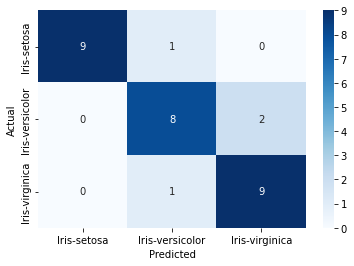

In [45]:
conf_matrix = confusion_matrix(test_labels, test_predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dl.labels, yticklabels=dl.labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

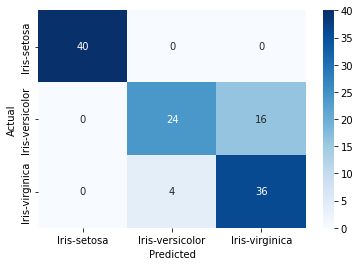

In [46]:
train_predicted_labels = mc.predict(vg_bool.x_train)
conf_matrix = confusion_matrix(train_labels, train_predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dl.labels, yticklabels=dl.labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Classification report

In [47]:
# Generate the test classification report
report = classification_report(test_labels, test_predicted_labels, target_names=dl.labels)
print(f"Test Error rate: {4/30}")
print(report)

Test Error rate: 0.13333333333333333
                 precision    recall  f1-score   support

    Iris-setosa       1.00      0.90      0.95        10
Iris-versicolor       0.80      0.80      0.80        10
 Iris-virginica       0.82      0.90      0.86        10

       accuracy                           0.87        30
      macro avg       0.87      0.87      0.87        30
   weighted avg       0.87      0.87      0.87        30



In [48]:
# Generate the train classification report
report = classification_report(train_labels, train_predicted_labels, target_names=dl.labels)
print(f"Train Error rate: {(20)/120}")
print(report)

Train Error rate: 0.16666666666666666
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        40
Iris-versicolor       0.86      0.60      0.71        40
 Iris-virginica       0.69      0.90      0.78        40

       accuracy                           0.83       120
      macro avg       0.85      0.83      0.83       120
   weighted avg       0.85      0.83      0.83       120



Looking at the error rates and confusion matrix we can conlude that the train and test errors are close each other. For the Iris-virginica we can find a high error in the prediction, also Iris-versicolor. The error is located between this two classes, and the best predicted is the Iris-setosa class.

# 5. Digit Classification

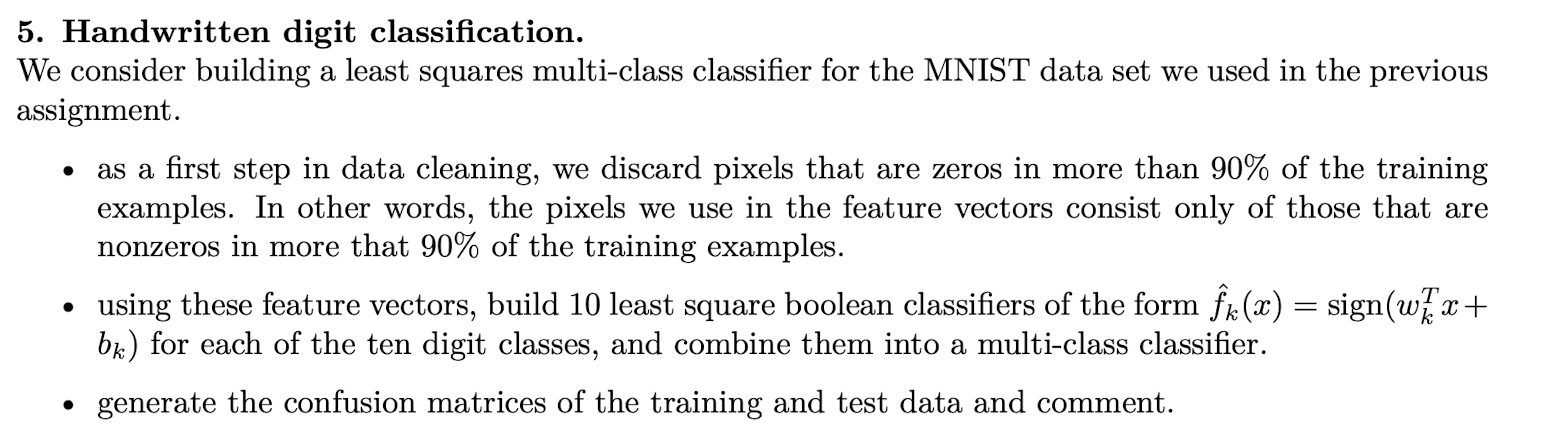

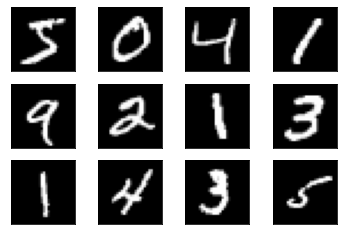

In [77]:
# read MNIST training data
df_train = pd.read_csv('data/mnist_train.csv')
df_test = pd.read_csv("data/mnist_test.csv")
df = pd.concat([df_train, df_test]).reset_index(drop=True)
data = df.iloc[:, 1:].to_numpy() / 255.0       # values are scaled to be between 0 and 1
labels = df.iloc[:, 0].to_numpy()                # labels of images



# plot the first dozen images from the data set
plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1, xticks=[], yticks=[])
    image = data[i, :].reshape((28,28))
    plt.imshow(image, cmap='gray')

## Remove zeros

In [78]:
# Calculate zero frequency
zero_frequency = np.mean(data == 0, axis=0)
keep_pixels = zero_frequency <= 0.9
data_reduced = data[:, keep_pixels]
df_data = pd.DataFrame(data_reduced)
df_data['labels'] = labels
df_data.head()

,0,1,2,3,4,5,6,7,8,9,...,334,335,336,337,338,339,340,341,342,labels
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,5
1,0.0,0.0,0.0,0.0,0.2,0.623529,0.992157,0.623529,0.196078,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.376471,0.0,0.0,0.0,0.000000,4
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.376471,0.988235,0.741176,0.164706,0.0,0.0,0.0,0.054902,9


## Define datasets for classifiers and create Boolean classifiers

In [99]:
# Load data in dataloader
lb = [0,1,2,3,4,5,6,7,8,9]
mnist_dl = DataLoader(df_data,
                      train_size=int(df_data.shape[0]*0.8572/10),
                      class_col='labels',
                      labels=lb)

x_train, x_test = mnist_dl.get_train_test_data(label_index=-1) # column position of the labels
train_labels, test_labels = mnist_dl.get_multiclass_labels_data()

In [80]:
# Get the datasets to train the boolean classifiers
mnist_classifiers = []
for label in lb:
  print(f"\nDefining data and classifier for label: {label}")
  y_train_set, Y_test_set = mnist_dl.get_single_class_label(label=label)
  c_bool = BoolClassifier(x_train, y_train_set, x_test, Y_test_set)
  c_bool.train(mode='solve') # Solved with QR fact but it is slow, with solve better timing solution 
  mnist_classifiers.append(c_bool)


Defining data and classifier for label: 0

Defining data and classifier for label: 1

Defining data and classifier for label: 2

Defining data and classifier for label: 3

Defining data and classifier for label: 4

Defining data and classifier for label: 5

Defining data and classifier for label: 6

Defining data and classifier for label: 7

Defining data and classifier for label: 8

Defining data and classifier for label: 9


## Multiclass classifier

In [102]:
mc_mnist = MultiClassifier(mnist_classifiers)
test_predicted_labels = mc_mnist.predict(x_test)

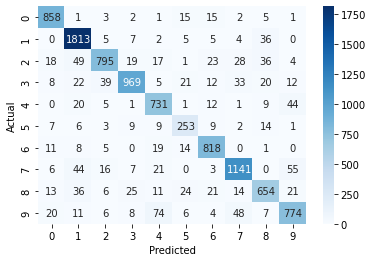

In [104]:
conf_matrix = confusion_matrix(test_labels, test_predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=mnist_dl.labels, yticklabels=mnist_dl.labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

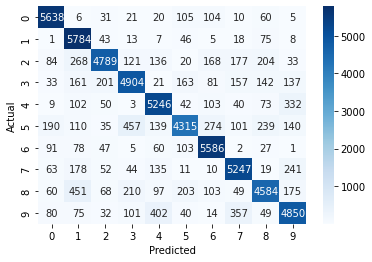

In [105]:
train_predicted_labels = mc_mnist.predict(x_train)
conf_matrix = confusion_matrix(train_labels, train_predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=mnist_dl.labels, yticklabels=mnist_dl.labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Classification Reports

In [111]:
lb = [str(x) for x in mnist_dl.labels]
# Generate the test classification report
report = classification_report(test_labels, test_predicted_labels, target_names=lb)
print(f"TEST CLASSIFICATION REPORT:\n{report}")

TEST CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       903
           1       0.90      0.97      0.93      1877
           2       0.90      0.80      0.85       990
           3       0.93      0.85      0.89      1141
           4       0.82      0.89      0.85       824
           5       0.74      0.81      0.77       313
           6       0.89      0.93      0.91       876
           7       0.90      0.88      0.89      1293
           8       0.84      0.79      0.81       825
           9       0.85      0.81      0.83       958

    accuracy                           0.88     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.88      0.88     10000



In [112]:
# Generate the train classification report
report = classification_report(train_labels, train_predicted_labels, target_names=lb)
print(f"TRAIN CLASSIFICATION REPORT:\n{report}")

TRAIN CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      6000
           1       0.80      0.96      0.88      6000
           2       0.90      0.80      0.84      6000
           3       0.83      0.82      0.83      6000
           4       0.84      0.87      0.86      6000
           5       0.85      0.72      0.78      6000
           6       0.87      0.93      0.90      6000
           7       0.85      0.87      0.86      6000
           8       0.84      0.76      0.80      6000
           9       0.82      0.81      0.81      6000

    accuracy                           0.85     60000
   macro avg       0.85      0.85      0.85     60000
weighted avg       0.85      0.85      0.85     60000



## Comments

- The train and test data was merged to then preprocess the information and extract randomly a percentage corresponding for the train and test data.
- The creation of the boolean classifiers use QR or solve tools from Scipy. For reducing training in the boolean classifiers was configured solve method, but still give the same results using QR factorization + solve_triangular.
- The accuracy and error rates in train and testing are aligned and close of each other. We found an accuracy of 85% for training and 88% for testing. It's a good accuracy for a multi-class classifier composed by individual boolean single-class classifiers.

# 6. Feature Engineering

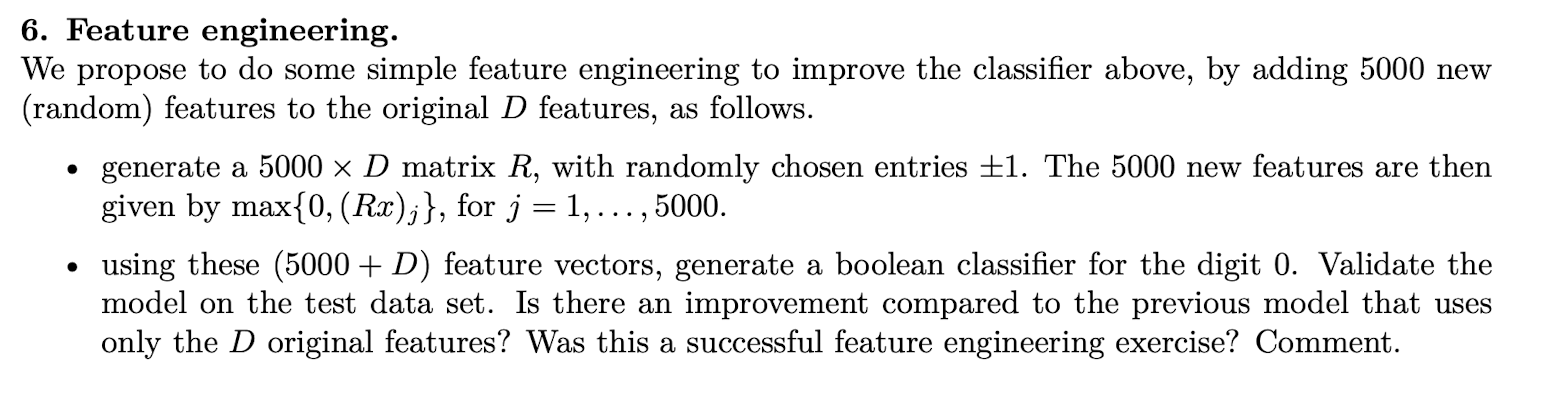

## Create new features

In [118]:
# remove zero's
zero_frequency = np.mean(data == 0, axis=0)
keep_pixels = zero_frequency <= 0.9
data_reduced = data[:, keep_pixels]

# Create R (5000xD)
D = data_reduced.shape[1]
R = np.random.choice([1, -1], size=(5000, D))
new_features = np.maximum(0, np.dot(R, data_reduced.T).T)
# concatenate with new features
data_extended = np.hstack((data_reduced, new_features))

# Convert to DataFrame
df_data = pd.DataFrame(data_extended)
df_data['labels'] = labels
df_data.head()

,0,1,2,3,4,5,6,7,8,9,...,5334,5335,5336,5337,5338,5339,5340,5341,5342,labels
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,3.737255,0.000000,0.0,0.000000,7.000000,0.000000,0.000000,7.062745,5
1,0.0,0.0,0.0,0.0,0.2,0.623529,0.992157,0.623529,0.196078,0.0,...,0.0,13.627451,0.000000,0.0,0.000000,3.360784,0.000000,3.941176,0.000000,0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,12.521569,0.0,6.145098,0.317647,2.529412,0.000000,0.000000,4
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,9.015686,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3.494118,1
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,7.262745,0.054902,0.0,0.047059,0.000000,14.023529,0.000000,9.678431,9


## Create boolean classifier for 0

In [119]:
# Load extended data in dataloader
lb = [0,1,2,3,4,5,6,7,8,9]
ext_dl = DataLoader(df_data,
                      train_size=int(df_data.shape[0]*0.8572/10),
                      class_col='labels',
                      labels=lb)

x_train, x_test = ext_dl.get_train_test_data(label_index=-1) # column position of the labels
train_labels, test_labels = ext_dl.get_multiclass_labels_data()

In [121]:
print(f"\nDefining data and classifier for label: 0")
y_train_set, Y_test_set = ext_dl.get_single_class_label(label=0)
c_bool = BoolClassifier(x_train, y_train_set, x_test, Y_test_set)
c_bool.train(mode='solve')


Defining data and classifier for label: 0


## Testing

In [136]:
test_predicted_labels = np.sign(c_bool.predict(x_test))
train_predicted_labels = np.sign(c_bool.predict(x_train))

## Confusion Matrix

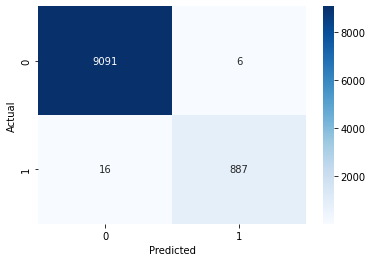

In [133]:
conf_matrix = confusion_matrix(Y_test_set.to_numpy(), test_predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

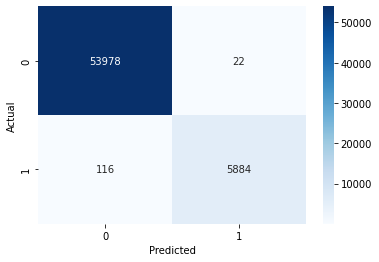

In [137]:
conf_matrix = confusion_matrix(y_train_set.to_numpy(), train_predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [140]:
((22+116)/60000)*100

0.22999999999999998

## Report Classification

In [138]:
lb = ['0', '1']
# Generate the test classification report
report = classification_report(Y_test_set.to_numpy(), test_predicted_labels, target_names=lb)
print(f"TEST CLASSIFICATION REPORT:\n{report}")
# Generate the train classification report
report = classification_report(y_train_set.to_numpy(), train_predicted_labels, target_names=lb)
print(f"TRAIN CLASSIFICATION REPORT:\n{report}")

TEST CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9097
           1       0.99      0.98      0.99       903

    accuracy                           1.00     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000

TRAIN CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54000
           1       1.00      0.98      0.99      6000

    accuracy                           1.00     60000
   macro avg       1.00      0.99      0.99     60000
weighted avg       1.00      1.00      1.00     60000



## Comments

- Adding the new features improved significantly the performance of the boolean classifier
- We can see that we have a percentage error of less than 0.5% for classifying the 0 from the rest of the numbers
- Combining multiple classifiers for the different classes using this new fetures will increase significantly the performance of the multi-class classifier.